In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [3]:
salary_file = pd.ExcelFile('../contract_data/salaries_1985to2020_final.xlsx')
salaries = pd.read_excel(salary_file, 0)
players_info = pd.read_excel(salary_file, 1)

In [4]:
### add years of the contract
years = list(salaries.groupby('player_id').apply(lambda x: [i for i in range(1, len(x)+1)]))
flatten = lambda l: [item for sublist in l for item in sublist]
salaries['years'] = flatten(years)

In [5]:
salaries_98_20 = salaries.loc[salaries['season_end'] >= 2006]
unique_ids = list(pd.unique(salaries_98_20['player_id']))
filtered_players_info = players_info.loc[[True if pid in unique_ids else False for pid in players_info['_id']]]

In [6]:
# Deal with rookie contracts of first round picks and second round picks
# separately. 
first_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '1st round']
second_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '2nd round']

In [7]:
salaries_first_round = salaries_98_20.loc[[True if pid in list(first_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 4 or less
# Prior to 2011 CBA, first round rookie contract is a 3+1 contract with the fourth year being team option
# After 2011 CBA, first round rookie contract is a 2+2 contract with both the 3rd and 4th year being team options
# Dropping values will potentially over-dropping some datapoints
salaries_first_round = salaries_first_round.loc[salaries_first_round['years'] > 4]

salaries_second_round = salaries_98_20.loc[[True if pid in list(second_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 3 or less
salaries_second_round = salaries_second_round.loc[salaries_second_round['years'] > 3]

In [8]:
# Following part is for fixing data in all stats

In [8]:
stats = pd.read_excel('../season_data/advanced_stats/FINAL_ADVANCED_STATS/all_seasons_advanced_stats.xlsx')

In [9]:
stats['error_in_name'] = stats['slug'].apply(lambda x: x is np.nan)
stats_need_fix = stats.loc[stats['error_in_name'] == True]

In [10]:
stats_need_fix['Year'] = '2019-20'
name = stats_need_fix['name'].apply(lambda x: re.sub(r"\\.+", "", x))
slug = stats_need_fix['name'].apply(lambda x: re.sub(r".+\\", "", x))
stats_need_fix['name'], stats_need_fix['slug'] = name, slug

<ipython-input-10-5b3e32999086>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_need_fix['Year'] = '2019-20'
<ipython-input-10-5b3e32999086>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_need_fix['name'], stats_need_fix['slug'] = name, slug


In [11]:
stats = stats.loc[stats['error_in_name'] == False].append(stats_need_fix).drop(columns=['error_in_name'])

In [12]:
# Create a primary key in two salaries table for joins
salaries_first_round['key'] = salaries_first_round['player_id'] + " " + salaries_first_round['season']
salaries_second_round['key'] = salaries_second_round['player_id'] + " " + salaries_second_round['season']
stats['key'] = stats['slug'] + " " + stats['Year']

In [13]:
salaries_stats_first_round = salaries_first_round.join(stats.set_index('key'), on='key', how='left').dropna()
salaries_stats_second_round = salaries_second_round.join(stats.set_index('key'), on='key', how='left').dropna()

In [14]:
first_round_counts = salaries_stats_first_round[['names', 'key']].groupby('key').count()
second_round_counts = salaries_stats_second_round[['names', 'key']].groupby('key').count()
not_traded_mid_season_first_round = list(first_round_counts.loc[first_round_counts['names'] == 1].index)
not_traded_mid_season_second_round = list(second_round_counts.loc[second_round_counts['names'] == 1].index)

In [15]:
salaries_stats_first_round = salaries_stats_first_round.reset_index().set_index('key').loc[not_traded_mid_season_first_round].reset_index().set_index('index')
salaries_stats_second_round = salaries_stats_second_round.reset_index().set_index('key').loc[not_traded_mid_season_second_round].reset_index().set_index('index')

In [16]:
salary_caps_file = pd.ExcelFile('salary_caps.xlsx')
salary_caps = pd.read_excel(salary_caps_file, 0)
salary_caps = salary_caps.drop(columns=salary_caps.columns[0])
salary_caps_99_20 = salary_caps.set_index('season').loc[np.unique(salaries_stats_first_round['season'])]

In [17]:
salaries_stats_first_round = salaries_stats_first_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_first_round = salaries_stats_first_round[salaries_stats_first_round['names'].notna()]
salaries_stats_second_round = salaries_stats_second_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_second_round = salaries_stats_second_round[salaries_stats_second_round['names'].notna()]

In [18]:
salaries_stats_first_round['cap_space_usage'] = salaries_stats_first_round['salary'] / salaries_stats_first_round['salary_cap']
salaries_stats_second_round['cap_space_usage'] = salaries_stats_second_round['salary'] / salaries_stats_second_round['salary_cap']
salaries_stats_first_round['minutes_per_game'] = salaries_stats_first_round['minutes_played'] / salaries_stats_first_round['games_played']
salaries_stats_second_round['minutes_per_game'] = salaries_stats_second_round['minutes_played'] / salaries_stats_second_round['games_played']
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['assist_percentage'] / salaries_stats_first_round['turnover_percentage']
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['assist_percentage'] / salaries_stats_second_round['turnover_percentage']
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting_percentage'] * salaries_stats_first_round['usage_percentage']
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting_percentage'] * salaries_stats_second_round['usage_percentage']

In [19]:
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting*usage'].replace([0], np.nan)
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting*usage'].replace([0], np.nan)

In [20]:
salaries_stats_first_round = salaries_stats_first_round.drop(columns=['player_id', 'season', 'season_end',
                                        'years', 'name', 'team',
                                        'slug', 'is_combined_totals', 'Year'])
salaries_stats_second_round = salaries_stats_second_round.drop(columns=['player_id', 'season', 'season_end',
                                        'years', 'name', 'team',
                                        'slug', 'is_combined_totals', 'Year'])
salaries_stats_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['minutes_played'] >= 700]
salaries_stats_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['minutes_played'] >= 700]

In [21]:
salaries_stats_first_round.columns

Index(['key', 'names', 'salary', 'season_start', 'positions', 'age',
       'games_played', 'minutes_played', 'player_efficiency_rating',
       'true_shooting_percentage', 'three_point_attempt_rate',
       'free_throw_attempt_rate', 'offensive_rebound_percentage',
       'defensive_rebound_percentage', 'total_rebound_percentage',
       'assist_percentage', 'steal_percentage', 'block_percentage',
       'turnover_percentage', 'usage_percentage', 'offensive_win_shares',
       'defensive_win_shares', 'win_shares', 'win_shares_per_48_minutes',
       'offensive_box_plus_minus', 'defensive_box_plus_minus',
       'box_plus_minus', 'value_over_replacement_player', 'salary_cap',
       'cap_space_usage', 'minutes_per_game', 'ast/tov_percentage',
       'true_shooting*usage'],
      dtype='object')

In [22]:
pg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POINT GUARD"].dropna()
sg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SHOOTING GUARD"].dropna()
sf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SMALL FORWARD"].dropna()
pf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POWER FORWARD"].dropna()
c_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "CENTER"].dropna()

In [23]:
pg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POINT GUARD"].dropna()
sg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SHOOTING GUARD"].dropna()
sf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SMALL FORWARD"].dropna()
pf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POWER FORWARD"].dropna()
c_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "CENTER"].dropna()

In [24]:
def find_percentile_for_feature(data, feature, percentile, position):
    return np.percentile(data.loc[(data['positions'] == position)][feature], percentile)

In [25]:
types = ['total_rebound_percentage',
        'assist_percentage',
        'three_point_attempt_rate',
        'block_percentage',
        'defensive_box_plus_minus',
        'steal_percentage']

In [26]:
def archtype_rewards_punishments(dataset, data, upper_p, lower_p, archtypes):
    # data: a Series containing data of a player
    # upper_p: upper percentile for specific statline
    # lower_p: lower percentile for specific statline
    # types: archtypes
    # return a list of weights
    pos = data.positions
    weights = []
    position_data = dataset.loc[dataset['positions'] == pos]
    cap_usage_mean = position_data['cap_space_usage'].mean()
    
    for archtype in archtypes:
        upper_value = find_percentile_for_feature(dataset, archtype, upper_p, pos)
        lower_value = find_percentile_for_feature(dataset, archtype, lower_p, pos)
        if data[archtype] >= upper_value:
            upper_mean = position_data.loc[position_data[archtype] >= upper_value]['cap_space_usage'].mean()
            weights.append(upper_mean - cap_usage_mean)
        elif data[archtype] <= lower_value:
            lower_mean = position_data.loc[position_data[archtype] <= lower_value]['cap_space_usage'].mean()
            weights.append(cap_usage_mean - lower_mean)
        else:
            weights.append(0)
                
    return weights

In [27]:
player = salaries_stats_first_round.iloc[1234]
sum(archtype_rewards_punishments(salaries_stats_first_round,
                            player,
                            80, 20, types))

0.04511149191045653

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [109]:
seed = 170

test = salaries_stats_second_round.loc[salaries_stats_second_round['season_start'] == 2019]
test_x = test[['age','player_efficiency_rating',
       'true_shooting*usage', 'offensive_box_plus_minus', 
       'value_over_replacement_player']]
test_y = test[['cap_space_usage']]

train = salaries_stats_second_round.loc[salaries_stats_second_round['season_start'] != 2019]
train = shuffle(train, random_state = seed)
train_x = train[['age','player_efficiency_rating',
       'true_shooting*usage', 'offensive_box_plus_minus', 
       'value_over_replacement_player']]
train_y = train[['cap_space_usage']]

In [112]:
train_length = int(len(train))
train_size = int(train_length*0.9)

t = train[:train_size]
t_x, t_y = train_x[:train_size], train_y[:train_size]

v = train[train_size:]
v_x, v_y = train_x[train_size:], train_y[train_size:]

model = LinearRegression().fit(t_x, t_y)

prediction = np.ndarray.flatten(model.predict(test_x))

predicted_salary = np.rint(prediction*test['salary_cap'].values)

print(mean_absolute_error(test['salary'].values, predicted_salary))

test['predicted_salary'] = predicted_salary
test[['names', 'salary', 'predicted_salary']]

<ipython-input-112-58adb57a8163>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_salary'] = predicted_salary


,names,salary,predicted_salary
index,,,
941,Will Barton,12960000,11725670.0
1199,DÄvis BertÄns,7000000,8838153.0
1217,Patrick Beverley,12345679,10312859.0
1292,Nemanja Bjelica,6825000,13211818.0
1412,Bojan BogdanoviÄ‡,17000000,12926027.0
1759,Malcolm Brogdon,20000000,12437195.0
2824,Pat Connaughton,1723050,6878673.0
3593,Spencer Dinwiddie,10600000,13228229.0
3724,Goran DragiÄ‡,19217900,14136368.0


In [29]:
seed = 234

test = salaries_stats_first_round.loc[salaries_stats_first_round['season_start'] == 2019]
test_x = test[['age','player_efficiency_rating',
       'true_shooting*usage', 'offensive_box_plus_minus', 
       'value_over_replacement_player']]
test_y = test[['cap_space_usage']]

train = salaries_stats_first_round.loc[salaries_stats_first_round['season_start'] != 2019]
train = shuffle(train, random_state = seed)
train_x = train[['age','player_efficiency_rating',
       'true_shooting*usage', 'offensive_box_plus_minus', 
       'value_over_replacement_player']]
train_y = train[['cap_space_usage']]

In [30]:
train_length = int(len(train))
train_size = int(train_length*0.9)

t = train[:train_size]
t_x, t_y = train_x[:train_size], train_y[:train_size]

v = train[train_size:]
v_x, v_y = train_x[train_size:], train_y[train_size:]

model = LinearRegression().fit(t_x, t_y)
prediction = np.ndarray.flatten(model.predict(v_x))

In [31]:
predicted_salary = prediction*train.iloc[train_size:]['salary_cap'].values

In [32]:
mean_absolute_error(train.iloc[train_size:]['salary'].values, predicted_salary)

3553488.6950751357

In [33]:
p_r = []
for i in test.index:
    p_r.append(sum(archtype_rewards_punishments(test, test.loc[i], 90, 10, types))/6)

In [35]:
prediction = np.ndarray.flatten(model.predict(test_x))
predicted_salary = np.rint((prediction+p_r)*test['salary_cap'].values)
mean_absolute_error(test['salary'].values, predicted_salary)

5962388.315789473

In [36]:
test['predicted_salary'] = predicted_salary
test[['names', 'salary', 'predicted_salary']]

<ipython-input-36-abbe7f8da1bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_salary'] = predicted_salary


,names,salary,predicted_salary
index,,,
81,Steven Adams,25842697,18328413.0
169,LaMarcus Aldridge,26000000,20682613.0
384,Kyle Anderson,9073050,10596209.0
455,Giannis Antetokounmpo,25842697,42401518.0
474,Carmelo Anthony,2159029,15538876.0
670,D.J. Augustin,7250000,21476966.0
862,Harrison Barnes,24147727,13080796.0
1057,Bradley Beal,27093019,25283225.0
1102,Marco Belinelli,5846154,11382493.0


11.6


0.23128578956525858

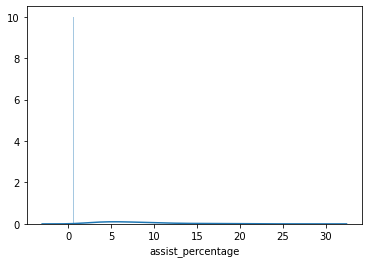

In [30]:
# Example 1
sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & (salaries_stats_first_round['minutes_played'] >= 700)]['assist_percentage'], bins=np.arange(0, 1, 0.1))
p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'assist_percentage', 80, 'CENTER')
print(p)
c = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['assist_percentage'] >= p)]
c['cap_space_usage'].mean()

0.1678


0.1420170617566977

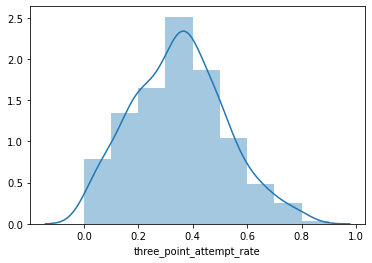

In [63]:
# Example 2
sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SHOOTING GUARD") &
                                                (salaries_stats_first_round['minutes_played'] >= 700)]['three_point_attempt_rate'],
                                                 bins=np.arange(0, 1, 0.1))
p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', 15, 'SHOOTING GUARD')
print(p)
sg = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SHOOTING GUARD") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['three_point_attempt_rate'] <= p)]
sg['cap_space_usage'].mean()

0.126


0.128253101373178

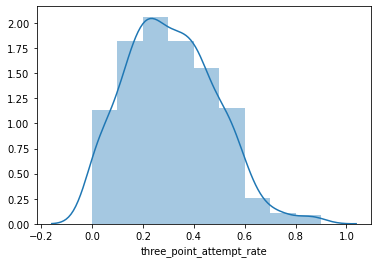

In [64]:
# Example 3
pos = 'SMALL FORWARD'

sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == pos) &
                                                (salaries_stats_first_round['minutes_played'] >= 700)]['three_point_attempt_rate'],
                                                 bins=np.arange(0, 1, 0.1))
p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', 15, pos)
print(p)
sf = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == pos) & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['three_point_attempt_rate'] <= p)]
sf['cap_space_usage'].mean()

22.8


<AxesSubplot:xlabel='cap_space_usage'>

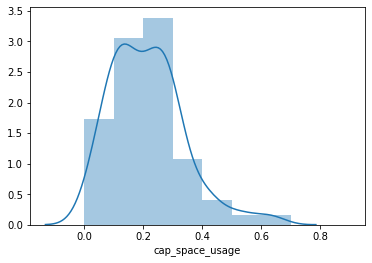

In [46]:
# Example 4

p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'defensive_rebound_percentage', 80, 'POWER FORWARD')
print(p)
pf = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "POWER FORWARD") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['defensive_rebound_percentage'] >= p)]
sns.distplot(pf['cap_space_usage'], bins=np.arange(0, 1, 0.1))

2.5600000000000023


0.1769962435425184

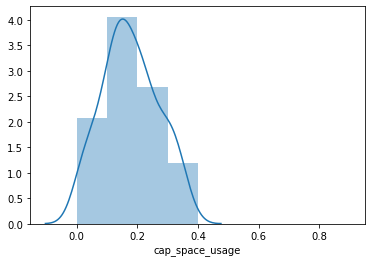

In [66]:
# Example 4

p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'steal_percentage', 80, 'POINT GUARD')
print(p)
pg = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == 'POINT GUARD') & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['steal_percentage'] >= p)]
sns.distplot(pg['cap_space_usage'], bins=np.arange(0, 1, 0.1))
pg['cap_space_usage'].mean()

In [24]:
def standardize(df, column):
    series = []
    for i in df[column]:
        series.append((i - df[column].mean())/df[column].std())
    return series

def correlation(df, column_1, column_2):
    return np.mean(df[column_1] * df[column_2])

def scatter_and_correlation(df, column_1, column_2, ax, order):
    copy = df.copy()
    copy[column_1 + "_standard"] = standardize(df, column_1)
    copy[column_2 + "_standard"] = standardize(df, column_2)
    copy.plot.scatter(x = column_1 + "_standard", y = column_2 + '_standard', ax=ax[order])
    return correlation(copy, column_1 + '_standard', column_2 + '_standard')

In [25]:
def side_by_side_correlation(filtered_data, unfiltered_data, feature):
    fig, ax = plt.subplots(1,2,figsize=(10, 5))
    corr_filtered = scatter_and_correlation(filtered_data, feature, 'cap_space_usage', ax, 0)
    corr_unfiltered = scatter_and_correlation(unfiltered_data, feature, 'cap_space_usage', ax, 1)
    return (corr_filtered, corr_unfiltered, feature)

In [ ]:
# Blocks below are for visualizations of unified 6 features

# No need to run them

In [ ]:
features = ['player_efficiency_rating',
              'ast/tov_percentage', 'true_shooting*usage', 'offensive_box_plus_minus', 'value_over_replacement_player', 'win_shares']

In [ ]:
correlations = {"C":{}, "PF":{}, "SF":{}, "SG":{}, "PG":{}}

In [ ]:
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(c_first_round.loc[c_first_round["minutes_played"] >= 700], c_first_round, feature)
    print(filtered, unfiltered, feature)
    correlations["C"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(pf_first_round.loc[pf_first_round["minutes_played"] >= 700], pf_first_round, feature)
    correlations["PF"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(sf_first_round.loc[sf_first_round["minutes_played"] >= 700], sf_first_round, feature)
    correlations["SF"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(sg_first_round.loc[sg_first_round["minutes_played"] >= 700], sg_first_round, feature)
    print(filtered, unfiltered, feature)
    correlations["SG"][feature] = filtered

for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(pg_first_round.loc[pg_first_round["minutes_played"] >= 700], pg_first_round, feature)
    correlations["PG"][feature] = filtered

In [ ]:
df = pd.DataFrame.from_dict({(i,j): correlations[i][j] 
                            for i in correlations.keys() 
                            for j in correlations[i].keys()},
                            orient='index')
df.index = pd.MultiIndex.from_tuples(df.index)
df = df.reset_index()
df = df.rename(columns={'level_0': "Position", "level_1": "Feature", 0: "Correlation with cap space usage"})

In [ ]:
for feature in features:
    print(side_by_side_correlation(c_second_round.loc[c_second_round["minutes_played"] >= 350], c_second_round, feature))

for feature in features:
    print(side_by_side_correlation(pf_second_round.loc[pf_second_round["minutes_played"] >= 350], pf_second_round, feature))

for feature in features:
    print(side_by_side_correlation(sf_second_round.loc[sf_second_round["minutes_played"] >= 350], sf_second_round, feature))

for feature in features:
    print(side_by_side_correlation(sg_second_round.loc[sg_second_round["minutes_played"] >= 350], sg_second_round, feature))

for feature in features:
    print(side_by_side_correlation(pg_second_round.loc[pg_second_round["minutes_played"] >= 350], pg_second_round, feature))